**Prueba de Grubbs**

In [31]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from scipy.stats import t, zscore
import random

In [40]:
def grubbs(X, test='two-tailed', alpha=0.05):
    '''
    Ejecuta el test de Grubbs recursivamente hasta que la hipótesis nula sea cierta.
    Parametros
    ----------
    X : ndarray
    El arreglo de numeros (numpy) sobre el cual se desea hallar outliers.
    test : str
    Describe los tipos de outliers que se están buscando. Puede ser 'min'
    (si se buscan los outliers muy pequeños), 'max' (si se buscan los grandes),
    o 'two-tailed' (si se buscan ambos).
    alpha : float
    El nivel de significancia.
    Retorna
    -------
    X : ndarray
    El arreglo original con los outliers removidos.
    outliers : ndarray
    Un arreglo de outliers.
    '''
    Z = zscore(X, ddof=1) # Z-score
    N = len(X) # Número de muestras
    # Calcula valores extremos y en valor crítico de la t de student
    if test == 'two-tailed':
        extreme_ix = lambda Z: np.abs(Z).argmax()
        t_crit = lambda N: t.isf(alpha / (2.*N), N-2)
    elif test == 'max':
        extreme_ix = lambda Z: Z.argmax()
        t_crit = lambda N: t.isf(alpha / N, N-2)
    elif test == 'min':
        extreme_ix = lambda Z: Z.argmin()
        t_crit = lambda N: t.isf(alpha / N, N-2)
    else:
        raise ValueError ("Test must be 'min', 'max', or 'two-tailed'")
    thresh = lambda N: (N - 1.) / np.sqrt(N) * \
        np.sqrt(t_crit(N)**2 / (N - 2 + t_crit(N)**2))
    # Crea un arreglo donde almacena los outliers
    outliers = np.array([])
    # Bucle sobre el arreglo de datos y remueve los outliers
    while abs(Z[extreme_ix(Z)]) > thresh(N):
        # actualiza los outliers
        outliers = np.r_[outliers, X[extreme_ix(Z)]]
        # remueve los outlier del arreglo
        X = np.delete(X, extreme_ix(Z))
        # recalcula el Z score
        Z = zscore(X, ddof=1)
        N = len(X)
        return X, outliers

In [41]:
np.random.seed(1548)
x1 = np.random.normal(30, 10, 20)
x2 = np.random.randint(50, 100, 2)
x = np.append(x1, x2)
print(x)

[25.70407946 41.84081878 40.90397337 34.28815348 24.79200971 25.41526208
 32.18174438 31.80755495 26.64518827 39.67046269 40.20563416 33.29813472
 28.31732909 18.26280697 32.78518143 11.63954665 32.69773757 35.02533554
 31.4466714  13.31562267 52.         68.        ]


In [42]:
grubbs(x)


(array([25.70407946, 41.84081878, 40.90397337, 34.28815348, 24.79200971,
        25.41526208, 32.18174438, 31.80755495, 26.64518827, 39.67046269,
        40.20563416, 33.29813472, 28.31732909, 18.26280697, 32.78518143,
        11.63954665, 32.69773757, 35.02533554, 31.4466714 , 13.31562267,
        52.        ]), array([68.]))

In [18]:
import numpy as np
import pandas as pd
import plotnine 
import statsmodels.formula.api as smf
from plotnine import ggplot, geom_point, aes, geom_abline


In [19]:
datos = pd.read_csv("medidas_cuerpo2.csv")

In [20]:
lm=smf.ols(formula = "Peso ~ Estatura", data = datos).fit()
lm.params


Intercept   -66.737734
Estatura     78.540296
dtype: float64

In [21]:
lm.rsquared

0.43827250709468557

In [23]:
n=datos.shape[0]
p=2
influence = lm.get_influence()


**Residuales estudentizados**

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


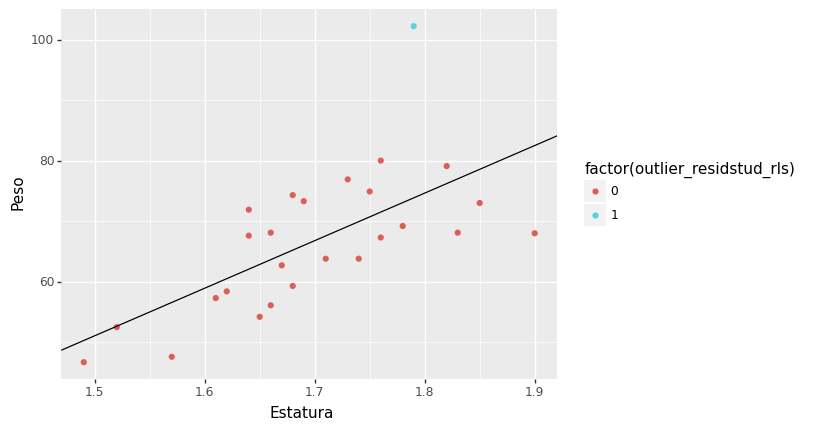

<ggplot: (8762202377313)>

In [22]:
resid_student = influence.resid_studentized_external
datos[['outlier_residstud_rls']] = np.where(abs(resid_student) >= 2, 1, 0)
(ggplot(datos, aes('Estatura', 'Peso', color='factor(outlier_residstud_rls)'))
 + geom_point()
 + geom_abline(intercept = lm.params[0], slope = lm.params[1], color = "black"))


**Distancia de Cook**

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


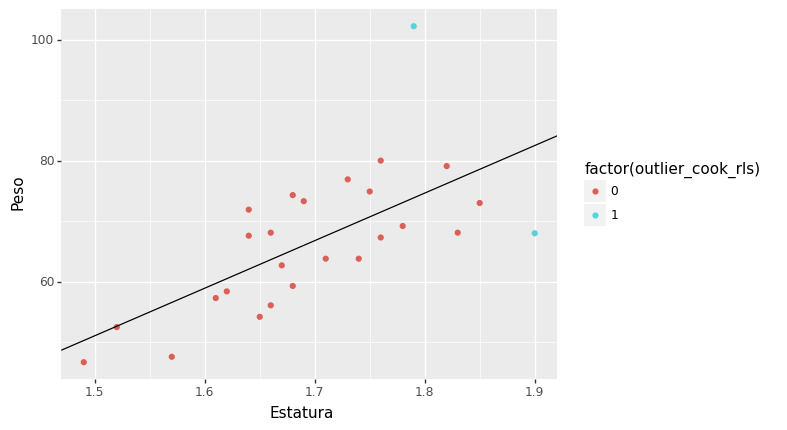

<ggplot: (8762213239753)>

In [24]:
(cooks, p) = influence.cooks_distance
datos[['outlier_cook_rls']] = np.where(cooks >= 4 /(n-2-2), 1, 0)
(ggplot(datos, aes('Estatura', 'Peso', color='factor(outlier_cook_rls)'))
 + geom_point()
 + geom_abline(intercept = lm.params[0], slope = lm.params[1], color = "black"))


**DFFIT**

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


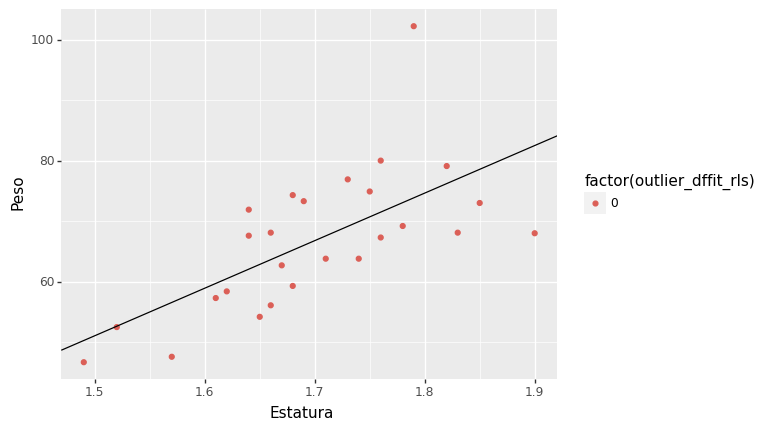

<ggplot: (8762202320429)>

In [25]:
(dffits, p) = influence.dffits
datos[['outlier_dffit_rls']] = np.where(dffits > 2 / np.sqrt(p/n), 1, 0)
(ggplot(datos, aes('Estatura', 'Peso', color='factor(outlier_dffit_rls)'))
 + geom_point()
 + geom_abline(intercept = lm.params[0], slope = lm.params[1], color = "black"))


**Leverege**

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


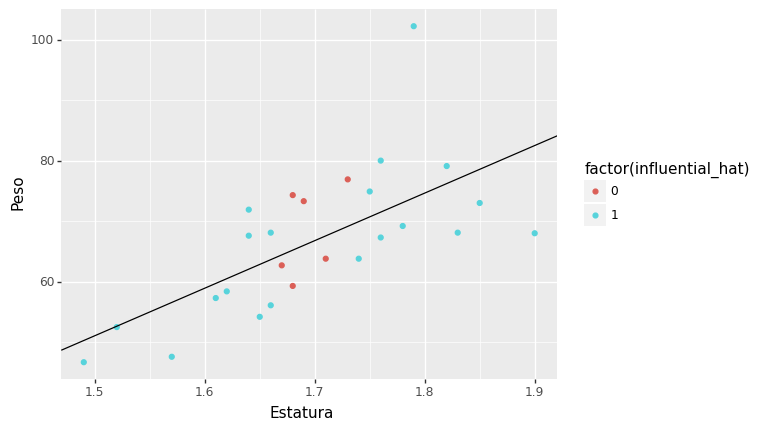

<ggplot: (8762202602237)>

In [10]:
leverage = influence.hat_matrix_diag
datos[['influential_hat']] = np.where(leverage >= 2*p/n, 1, 0)
(ggplot(datos, aes('Estatura', 'Peso', color='factor(influential_hat)'))
 + geom_point()
 + geom_abline(intercept = lm.params[0], slope = lm.params[1], color = "black"))


**Regresión múltiple**

In [26]:
datos = pd.read_csv("medidas_cuerpo2.csv")
lm2 = smf.ols(formula = "Peso~Estatura+circun_cuello+circun_muneca", data = datos).fit()
n=datos.shape[0]
p=4
lm2.params


Intercept       -62.018297
Estatura          9.440395
circun_cuello     2.258735
circun_muneca     1.989082
dtype: float64

In [12]:
lm2.params

Intercept       -62.018297
Estatura          9.440395
circun_cuello     2.258735
circun_muneca     1.989082
dtype: float64

In [27]:
influence_rlm = lm2.get_influence()
resid_student_rlm = influence_rlm .resid_studentized_external
(cooks_rlm, p_cooks_rlm) = influence_rlm.cooks_distance
(dffits_rlm, p_dffits_rlm) = influence_rlm.dffits
leverage_rlm = influence_rlm.hat_matrix_diag


In [28]:
datos[['outlier_residstud_rlm']] = np.where(abs(resid_student_rlm) >= 2, 1, 0)
datos[['outlier_cook_rlm']] = np.where(cooks_rlm >= 4 /(n-2-2), 1, 0)
datos[['outlier_dffit_rlm']] = np.where(dffits_rlm > 2 * np.sqrt(p/n), 1, 0)
datos[['influential_hat_rlm']] = np.where(leverage_rlm >= 2*p/n, 1, 0)


In [29]:
df_outliers = datos.query('outlier_residstud_rlm == 1 | outlier_cook_rlm == 1 | outlier_dffit_rlm == 1')
df_outliers


,ID,Peso,Sexo,Estatura,circun_cuello,circun_muneca,outlier_residstud_rlm,outlier_cook_rlm,outlier_dffit_rlm,influential_hat_rlm
7,8,69.2,M,1.78,40.5,16.5,0,1,0,0
10,11,102.2,M,1.79,41.5,17.1,1,1,1,0


In [30]:
df_outliers = df_outliers.drop(['outlier_residstud_rlm','outlier_cook_rlm', 'outlier_dffit_rlm', 'influential_hat_rlm'], 1)
df_outliers


,ID,Peso,Sexo,Estatura,circun_cuello,circun_muneca
7,8,69.2,M,1.78,40.5,16.5
10,11,102.2,M,1.79,41.5,17.1
